In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data into a pandas DataFrame
data = pd.read_csv('GazeDataMonde\gaze_data_all_trials.csv', sep=',')

# Define screen resolution (you can adjust this based on Unity's settings)
screen_width = 3840
screen_height = 2160

In [6]:
! pip install numpy

In [16]:

# Step 1: Compute Eye Movement Velocity
def compute_velocity(df):
    df['FrameDiff'] = df['RelativeFrameNumber'].diff().fillna(1)  # Avoid division by zero, fill NaN with 1
    df['PosDiff'] = np.sqrt((df['BestPogX'].diff() ** 2) + (df['BestPogY'].diff() ** 2))
    df['PosDiff'].fillna(0, inplace=True)  # Replace NaN with 0
    df['Velocity'] = df['PosDiff'] / df['FrameDiff'].replace(0, 1e-5)  # Replace zero with a small value
    return df

# Step 2: Compute Accuracy Relative to the Ball Position (separate X and Y)
def compute_accuracy(df, screen_width, screen_height):
    df['MappedPogX'] = df['BestPogX'] * screen_width
    df['MappedPogY'] = df['BestPogY'] * screen_height
    # 3d
    # df[['BallX', 'BallY']] = df['ScreenBallPosition'].str.extract(r'\((\d+\.?\d*)\s(\d+\.?\d*)\s\d+\.?\d*\)').astype(float)

    #2d
    df[['BallX', 'BallY']] = df['ScreenBallPosition'].str.extract(r'\((\d+\.?\d*)\s(\d+\.?\d*)\)').astype(float)
    df = df[(df['BallX'] >= 0) & (df['BallY'] >= 0)]
    df['AccuracyX'] = np.abs(df['MappedPogX'] - df['BallX'])
    df['AccuracyY'] = np.abs(df['MappedPogY'] - df['BallY'])
    return df

# Step 1: Align frame numbers and average across trials of the same type (trialID)
def align_and_average_across_trials(df, screen_width, screen_height):
    # Align Frame Numbers: Create RelativeFrameNumber for each trial
    df['RelativeFrameNumber'] = df.groupby('TrialNumber')['FrameNumber'].transform(lambda x: x - x.min())
    # Compute Velocity and Accuracy
    df = compute_velocity(df)
    df = compute_accuracy(df, screen_width, screen_height)
    
    # Find the maximum duration (relative frame number) for each trialID
    max_duration = df.groupby('TrialID')['RelativeFrameNumber'].max().max()

    # Step 2: Interpolate missing values for shorter trials
    all_relative_frames = pd.DataFrame({'RelativeFrameNumber': np.arange(max_duration + 1)})
    avg_df = []
    
    for trial_id in df['TrialID'].unique():
        trial_data = df[df['TrialID'] == trial_id]
        
        # Group by TrialNum to align and interpolate each trial
        # trial_grouped = trial_data.groupby('TrialNumber').apply(lambda group: group.set_index('RelativeFrameNumber').reindex(np.arange(max_duration + 1)).interpolate(limit_direction='both', method='linear')).reset_index()

        # Now average across all trials of the same type (trialID)
        avg_by_trial_id = trial_data.groupby('RelativeFrameNumber').agg(
            AvgVelocity=('Velocity', 'mean'),
            AvgAccuracyX=('AccuracyX', 'mean'),
            AvgAccuracyY=('AccuracyY', 'mean')
        ).reset_index()
        
        avg_by_trial_id['TrialID'] = trial_id
        avg_df.append(avg_by_trial_id)

    # Concatenate all averaged trials
    avg_df = pd.concat(avg_df)
    return avg_df

# Step 3: Plot the aligned and averaged metrics by trialID
def plot_aligned_average_metrics_by_trialID(avg_df, screen_width, screen_height):
    trial_ids = sorted(avg_df['TrialID'].unique())  # Ensure TrialIDs are ordered
    num_trials = len(trial_ids)
    num_rows = (num_trials + 1) // 2  # Each row contains 2 trials

    # Create subplots: 6 columns (2 trials per row, each with velocity and X/Y accuracy)
    fig, axes = plt.subplots(num_rows, 6, figsize=(30, 5 * num_rows), sharex=True)

    for i, trial_id in enumerate(trial_ids):
        trial_avg = avg_df[avg_df['TrialID'] == trial_id]

        row = i // 2
        col_velocity = (i % 2) * 3  # First column for velocity
        col_accuracy_x = col_velocity + 1  # Second column for X accuracy
        col_accuracy_y = col_velocity + 2  # Third column for Y accuracy

        # Plot average Velocity in the first column for each trialID
        ax_velocity = axes[row, col_velocity]
        ax_velocity.plot(trial_avg['RelativeFrameNumber'], trial_avg['AvgVelocity'], color='blue', label='Avg Velocity')
        ax_velocity.set_ylabel('Avg Velocity (pixels/frame)', color='blue')
        ax_velocity.tick_params(axis='y', labelcolor='blue')
        ax_velocity.set_title(f'TrialID: {trial_id} - Avg Velocity')
        ax_velocity.set_ylim([0, 3000])
        ax_velocity.set_xlabel('Relative Frame Number')

        # Plot average Accuracy (X) in the second column for each trial
        ax_accuracy_x = axes[row, col_accuracy_x]
        ax_accuracy_x.plot(trial_avg['RelativeFrameNumber'], trial_avg['AvgAccuracyX'], color='green', label='Avg Accuracy X')
        ax_accuracy_x.set_ylabel('Avg Accuracy X (pixels)', color='green')
        ax_accuracy_x.tick_params(axis='y', labelcolor='green')
        ax_accuracy_x.set_title(f'TrialID: {trial_id} - Avg Accuracy X')
        ax_accuracy_x.set_ylim([0, 1000])
        ax_accuracy_x.set_xlabel('Relative Frame Number')

        # Plot average Accuracy (Y) in the third column for each trial
        ax_accuracy_y = axes[row, col_accuracy_y]
        ax_accuracy_y.plot(trial_avg['RelativeFrameNumber'], trial_avg['AvgAccuracyY'], color='red', label='Avg Accuracy Y')
        ax_accuracy_y.set_ylabel('Avg Accuracy Y (pixels)', color='red')
        ax_accuracy_y.tick_params(axis='y', labelcolor='red')
        ax_accuracy_y.set_title(f'TrialID: {trial_id} - Avg Accuracy Y')
        ax_accuracy_y.set_ylim([0, 1000])
        ax_accuracy_y.set_xlabel('Relative Frame Number')

    fig.tight_layout()
    plt.show()

# Step 4: Align, average, and plot metrics
aligned_avg_data_by_trial = align_and_average_across_trials(data, screen_width, screen_height)
plot_aligned_average_metrics_by_trialID(aligned_avg_data_by_trial, screen_width, screen_height)


C:\Users\jk8659\AppData\Local\Temp\ipykernel_71896\482617352.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['PosDiff'].fillna(0, inplace=True)  # Replace NaN with 0


ValueError: arange: cannot compute length

In [17]:
# Step 1: Align frame numbers, normalize to [0, 1], and average across trials of the same type (trialID)
def align_and_average_across_trials(df, screen_width, screen_height):
    # Align Frame Numbers: Create RelativeFrameNumber for each trial
    df['RelativeFrameNumber'] = df.groupby('TrialNumber')['FrameNumber'].transform(lambda x: x - x.min())
    
    # Compute Velocity and Accuracy
    df = compute_velocity(df)
    df = compute_accuracy(df, screen_width, screen_height)
    
    # Normalize Relative Frame Number to the range [0, 1]
    df['MaxRelativeFrame'] = df.groupby('TrialNumber')['RelativeFrameNumber'].transform('max')
    df['NormalizedFrameNumber'] = df['RelativeFrameNumber'] / df['MaxRelativeFrame']

    avg_df = []
    
    for trial_id in df['TrialID'].unique():
        trial_data = df[df['TrialID'] == trial_id]

        # Now average across all trials of the same type (trialID)
        avg_by_trial_id = trial_data.groupby('NormalizedFrameNumber').agg(
            AvgVelocity=('Velocity', 'mean'),
            AvgAccuracyX=('AccuracyX', 'mean'),
            AvgAccuracyY=('AccuracyY', 'mean')
        ).reset_index()
        
        avg_by_trial_id['TrialID'] = trial_id
        avg_df.append(avg_by_trial_id)

    # Concatenate all averaged trials
    avg_df = pd.concat(avg_df)
    return avg_df

# Step 3: Plot the aligned and averaged metrics by trialID
def plot_aligned_average_metrics_by_trialID(avg_df, screen_width, screen_height):
    trial_ids = sorted(avg_df['TrialID'].unique())  # Ensure TrialIDs are ordered
    num_trials = len(trial_ids)
    num_rows = (num_trials + 1) // 2  # Each row contains 2 trials

    # Create subplots: 6 columns (2 trials per row, each with velocity and X/Y accuracy)
    fig, axes = plt.subplots(num_rows, 6, figsize=(30, 5 * num_rows), sharex=True)

    for i, trial_id in enumerate(trial_ids):
        trial_avg = avg_df[avg_df['TrialID'] == trial_id]

        row = i // 2
        col_velocity = (i % 2) * 3  # First column for velocity
        col_accuracy_x = col_velocity + 1  # Second column for X accuracy
        col_accuracy_y = col_velocity + 2  # Third column for Y accuracy

        # Plot average Velocity in the first column for each trialID
        ax_velocity = axes[row, col_velocity]
        ax_velocity.plot(trial_avg['NormalizedFrameNumber'], trial_avg['AvgVelocity'], color='blue', label='Avg Velocity')
        ax_velocity.set_ylabel('Avg Velocity (pixels/frame)', color='blue')
        ax_velocity.tick_params(axis='y', labelcolor='blue')
        ax_velocity.set_title(f'TrialID: {trial_id} - Avg Velocity')
        ax_velocity.set_ylim([0, 3000])
        ax_velocity.set_xlabel('Normalized Frame Number')

        # Plot average Accuracy (X) in the second column for each trial
        ax_accuracy_x = axes[row, col_accuracy_x]
        ax_accuracy_x.plot(trial_avg['NormalizedFrameNumber'], trial_avg['AvgAccuracyX'], color='green', label='Avg Accuracy X')
        ax_accuracy_x.set_ylabel('Avg Accuracy X (pixels)', color='green')
        ax_accuracy_x.tick_params(axis='y', labelcolor='green')
        ax_accuracy_x.set_title(f'TrialID: {trial_id} - Avg Accuracy X')
        ax_accuracy_x.set_ylim([0, 1000])
        ax_accuracy_x.set_xlabel('Normalized Frame Number')

        # Plot average Accuracy (Y) in the third column for each trial
        ax_accuracy_y = axes[row, col_accuracy_y]
        ax_accuracy_y.plot(trial_avg['NormalizedFrameNumber'], trial_avg['AvgAccuracyY'], color='red', label='Avg Accuracy Y')
        ax_accuracy_y.set_ylabel('Avg Accuracy Y (pixels)', color='red')
        ax_accuracy_y.tick_params(axis='y', labelcolor='red')
        ax_accuracy_y.set_title(f'TrialID: {trial_id} - Avg Accuracy Y')
        ax_accuracy_y.set_ylim([0, 1000])
        ax_accuracy_y.set_xlabel('Normalized Frame Number')

    fig.tight_layout()
    plt.show()

# Step 4: Align, average, and plot metrics with normalized frame numbers
aligned_avg_data_by_trial = align_and_average_across_trials(data, screen_width, screen_height)
plot_aligned_average_metrics_by_trialID(aligned_avg_data_by_trial, screen_width, screen_height)


C:\Users\jk8659\AppData\Local\Temp\ipykernel_71896\482617352.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['PosDiff'].fillna(0, inplace=True)  # Replace NaN with 0


ValueError: No objects to concatenate

In [18]:

# Step 1: Align frame numbers, normalize to [0, 1], and average across trials of the same type (trialID) with MSE
def align_and_average_across_trials(df, screen_width, screen_height):
    # Align Frame Numbers: Create RelativeFrameNumber for each trial
    df['RelativeFrameNumber'] = df.groupby('TrialNumber')['FrameNumber'].transform(lambda x: x - x.min())
    
    # Compute Velocity and Accuracy
    df = compute_velocity(df)
    df = compute_accuracy(df, screen_width, screen_height)
    
    # Normalize Relative Frame Number to the range [0, 1]
    df['MaxRelativeFrame'] = df.groupby('TrialNumber')['RelativeFrameNumber'].transform('max')
    df['NormalizedFrameNumber'] = df['RelativeFrameNumber'] / df['MaxRelativeFrame']

    # Find the maximum duration (normalized frame number) across all trials
    max_duration = df.groupby('TrialID')['NormalizedFrameNumber'].max().max()

    # Step 2: Interpolate missing values for shorter trials
    all_normalized_frames = pd.DataFrame({'NormalizedFrameNumber': np.linspace(0, max_duration, num=100)})  # You can set 100 or any resolution
    
    avg_df = []
    
    for trial_id in df['TrialID'].unique():
        trial_data = df[df['TrialID'] == trial_id]
    

        # Now calculate mean and MSE across all trials of the same type (trialID)
        avg_by_trial_id = trial_data.groupby('NormalizedFrameNumber').agg(
            AvgVelocity=('Velocity', 'mean'),
            MSEVelocity=('Velocity', lambda x: np.mean((x - x.mean())**2)),
            AvgAccuracyX=('AccuracyX', 'mean'),
            MSEAccuracyX=('AccuracyX', lambda x: np.mean((x - x.mean())**2)),
            AvgAccuracyY=('AccuracyY', 'mean'),
            MSEAccuracyY=('AccuracyY', lambda x: np.mean((x - x.mean())**2))
        ).reset_index()
        
        avg_by_trial_id['TrialID'] = trial_id
        avg_df.append(avg_by_trial_id)

    # Concatenate all averaged trials
    avg_df = pd.concat(avg_df)
    return avg_df

# Step 3: Plot the aligned and averaged metrics by trialID with MSE regions
def plot_aligned_average_metrics_by_trialID(avg_df, screen_width, screen_height):
    trial_ids = sorted(avg_df['TrialID'].unique())  # Ensure TrialIDs are ordered
    num_trials = len(trial_ids)
    num_rows = (num_trials + 1) // 2  # Each row contains 2 trials

    # Create subplots: 6 columns (2 trials per row, each with velocity and X/Y accuracy)
    fig, axes = plt.subplots(num_rows, 6, figsize=(30, 5 * num_rows), sharex=True)

    for i, trial_id in enumerate(trial_ids):
        trial_avg = avg_df[avg_df['TrialID'] == trial_id]

        row = i // 2
        col_velocity = (i % 2) * 3  # First column for velocity
        col_accuracy_x = col_velocity + 1  # Second column for X accuracy
        col_accuracy_y = col_velocity + 2  # Third column for Y accuracy

        # Plot average Velocity and MSE region in the first column for each trialID
        ax_velocity = axes[row, col_velocity]
        ax_velocity.plot(trial_avg['NormalizedFrameNumber'], trial_avg['AvgVelocity'], color='blue', label='Avg Velocity')
        ax_velocity.fill_between(trial_avg['NormalizedFrameNumber'],
                                 trial_avg['AvgVelocity'] - np.sqrt(trial_avg['MSEVelocity']),
                                 trial_avg['AvgVelocity'] + np.sqrt(trial_avg['MSEVelocity']),
                                 color='blue', alpha=0.2, label='MSE Region')
        ax_velocity.set_ylabel('Avg Velocity (pixels/frame)', color='blue')
        ax_velocity.tick_params(axis='y', labelcolor='blue')
        ax_velocity.set_title(f'TrialID: {trial_id} - Avg Velocity')
        ax_velocity.set_ylim([0, 3000])
        ax_velocity.set_xlabel('Normalized Frame Number')

        # Plot average Accuracy (X) and MSE region in the second column for each trial
        ax_accuracy_x = axes[row, col_accuracy_x]
        ax_accuracy_x.plot(trial_avg['NormalizedFrameNumber'], trial_avg['AvgAccuracyX'], color='green', label='Avg Accuracy X')
        ax_accuracy_x.fill_between(trial_avg['NormalizedFrameNumber'],
                                   trial_avg['AvgAccuracyX'] - np.sqrt(trial_avg['MSEAccuracyX']),
                                   trial_avg['AvgAccuracyX'] + np.sqrt(trial_avg['MSEAccuracyX']),
                                   color='green', alpha=0.2, label='MSE Region')
        ax_accuracy_x.set_ylabel('Avg Accuracy X (pixels)', color='green')
        ax_accuracy_x.tick_params(axis='y', labelcolor='green')
        ax_accuracy_x.set_title(f'TrialID: {trial_id} - Avg Accuracy X')
        ax_accuracy_x.set_ylim([0, 1000])
        ax_accuracy_x.set_xlabel('Normalized Frame Number')

        # Plot average Accuracy (Y) and MSE region in the third column for each trial
        ax_accuracy_y = axes[row, col_accuracy_y]
        ax_accuracy_y.plot(trial_avg['NormalizedFrameNumber'], trial_avg['AvgAccuracyY'], color='red', label='Avg Accuracy Y')
        ax_accuracy_y.fill_between(trial_avg['NormalizedFrameNumber'],
                                   trial_avg['AvgAccuracyY'] - np.sqrt(trial_avg['MSEAccuracyY']),
                                   trial_avg['AvgAccuracyY'] + np.sqrt(trial_avg['MSEAccuracyY']),
                                   color='red', alpha=0.2, label='MSE Region')
        ax_accuracy_y.set_ylabel('Avg Accuracy Y (pixels)', color='red')
        ax_accuracy_y.tick_params(axis='y', labelcolor='red')
        ax_accuracy_y.set_title(f'TrialID: {trial_id} - Avg Accuracy Y')
        ax_accuracy_y.set_ylim([0, 1000])
        ax_accuracy_y.set_xlabel('Normalized Frame Number')

    fig.tight_layout()
    plt.show()

# Step 4: Align, average, and plot metrics with normalized frame numbers and MSE regions
aligned_avg_data_by_trial = align_and_average_across_trials(data, screen_width, screen_height)
plot_aligned_average_metrics_by_trialID(aligned_avg_data_by_trial, screen_width, screen_height)


C:\Users\jk8659\AppData\Local\Temp\ipykernel_71896\482617352.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['PosDiff'].fillna(0, inplace=True)  # Replace NaN with 0


ValueError: No objects to concatenate

Second half of trials


In [10]:
# Step 1: Align frame numbers, normalize to [0, 1], and average across the first half of the trials
def align_and_average_across_first_half_trials(df, screen_width, screen_height):
    # Get the unique TrialNumbers and select the first half
    unique_trials = df['TrialNumber'].unique()
    first_half_trial_count = len(unique_trials) // 2
    first_half_trials = unique_trials[:first_half_trial_count]  # Select the first half of the trials
    
    # Filter the data to only include the first half of the trials
    df_first_half = df[df['TrialNumber'].isin(first_half_trials)]
    
    # Align Frame Numbers: Create RelativeFrameNumber for each trial
    df_first_half['RelativeFrameNumber'] = df_first_half.groupby('TrialNumber')['FrameNumber'].transform(lambda x: x - x.min())
    
    # Compute Velocity and Accuracy
    df_first_half = compute_velocity(df_first_half)
    df_first_half = compute_accuracy(df_first_half, screen_width, screen_height)
    
    # Normalize Relative Frame Number to the range [0, 1]
    df_first_half['MaxRelativeFrame'] = df_first_half.groupby('TrialNumber')['RelativeFrameNumber'].transform('max')
    df_first_half['NormalizedFrameNumber'] = df_first_half['RelativeFrameNumber'] / df_first_half['MaxRelativeFrame']

    # Find the maximum duration (normalized frame number) across all trials
    max_duration = df_first_half.groupby('TrialID')['NormalizedFrameNumber'].max().max()

    # Step 2: Interpolate missing values for shorter trials
    all_normalized_frames = pd.DataFrame({'NormalizedFrameNumber': np.linspace(0, max_duration, num=100)})  # You can set 100 or any resolution
    
    avg_df = []
    
    for trial_id in df_first_half['TrialID'].unique():
        trial_data = df_first_half[df_first_half['TrialID'] == trial_id]
    

        # Now calculate mean and MSE across all trials of the same type (trialID)
        avg_by_trial_id = trial_data.groupby('NormalizedFrameNumber').agg(
            AvgVelocity=('Velocity', 'mean'),
            MSEVelocity=('Velocity', lambda x: np.mean((x - x.mean())**2)),
            AvgAccuracyX=('AccuracyX', 'mean'),
            MSEAccuracyX=('AccuracyX', lambda x: np.mean((x - x.mean())**2)),
            AvgAccuracyY=('AccuracyY', 'mean'),
            MSEAccuracyY=('AccuracyY', lambda x: np.mean((x - x.mean())**2))
        ).reset_index()
        
        avg_by_trial_id['TrialID'] = trial_id
        avg_df.append(avg_by_trial_id)

    # Concatenate all averaged trials
    avg_df = pd.concat(avg_df)
    return avg_df

# Step 2: Plot the aligned and averaged metrics by trialID for the first half of the trials
def plot_aligned_average_metrics_by_trialID_first_half(avg_df, screen_width, screen_height):
    trial_ids = sorted(avg_df['TrialID'].unique())  # Ensure TrialIDs are ordered
    num_trials = len(trial_ids)
    num_rows = (num_trials + 1) // 2  # Each row contains 2 trials

    # Create subplots: 6 columns (2 trials per row, each with velocity and X/Y accuracy)
    fig, axes = plt.subplots(num_rows, 6, figsize=(30, 5 * num_rows), sharex=True)

    for i, trial_id in enumerate(trial_ids):
        trial_avg = avg_df[avg_df['TrialID'] == trial_id]

        row = i // 2
        col_velocity = (i % 2) * 3  # First column for velocity
        col_accuracy_x = col_velocity + 1  # Second column for X accuracy
        col_accuracy_y = col_accuracy_x + 1  # Third column for Y accuracy

        # Plot average Velocity and MSE region in the first column for each trialID
        ax_velocity = axes[row, col_velocity]
        ax_velocity.plot(trial_avg['NormalizedFrameNumber'], trial_avg['AvgVelocity'], color='blue', label='Avg Velocity')
        ax_velocity.fill_between(trial_avg['NormalizedFrameNumber'],
                                 trial_avg['AvgVelocity'] - np.sqrt(trial_avg['MSEVelocity']),
                                 trial_avg['AvgVelocity'] + np.sqrt(trial_avg['MSEVelocity']),
                                 color='blue', alpha=0.2, label='MSE Region')
        ax_velocity.set_ylabel('Avg Velocity (pixels/frame)', color='blue')
        ax_velocity.tick_params(axis='y', labelcolor='blue')
        ax_velocity.set_title(f'TrialID: {trial_id} - Avg Velocity')
        ax_velocity.set_ylim([0, 5000])
        ax_velocity.set_xlabel('Normalized Frame Number')

        # Plot average Accuracy (X) and MSE region in the second column for each trial
        ax_accuracy_x = axes[row, col_accuracy_x]
        ax_accuracy_x.plot(trial_avg['NormalizedFrameNumber'], trial_avg['AvgAccuracyX'], color='green', label='Avg Accuracy X')
        ax_accuracy_x.fill_between(trial_avg['NormalizedFrameNumber'],
                                   trial_avg['AvgAccuracyX'] - np.sqrt(trial_avg['MSEAccuracyX']),
                                   trial_avg['AvgAccuracyX'] + np.sqrt(trial_avg['MSEAccuracyX']),
                                   color='green', alpha=0.2, label='MSE Region')
        ax_accuracy_x.set_ylabel('Avg Accuracy X (pixels)', color='green')
        ax_accuracy_x.tick_params(axis='y', labelcolor='green')
        ax_accuracy_x.set_title(f'TrialID: {trial_id} - Avg Accuracy X')
        ax_accuracy_x.set_ylim([0, 2000])
        ax_accuracy_x.set_xlabel('Normalized Frame Number')

        # Plot average Accuracy (Y) and MSE region in the third column for each trial
        ax_accuracy_y = axes[row, col_accuracy_y]
        ax_accuracy_y.plot(trial_avg['NormalizedFrameNumber'], trial_avg['AvgAccuracyY'], color='red', label='Avg Accuracy Y')
        ax_accuracy_y.fill_between(trial_avg['NormalizedFrameNumber'],
                                   trial_avg['AvgAccuracyY'] - np.sqrt(trial_avg['MSEAccuracyY']),
                                   trial_avg['AvgAccuracyY'] + np.sqrt(trial_avg['MSEAccuracyY']),
                                   color='red', alpha=0.2, label='MSE Region')
        ax_accuracy_y.set_ylabel('Avg Accuracy Y (pixels)', color='red')
        ax_accuracy_y.tick_params(axis='y', labelcolor='red')
        ax_accuracy_y.set_title(f'TrialID: {trial_id} - Avg Accuracy Y')
        ax_accuracy_y.set_ylim([0, 2000])
        ax_accuracy_y.set_xlabel('Normalized Frame Number')

    fig.tight_layout()
    plt.show()

# Step 3: Align, average, and plot metrics for the first half of the trials
aligned_avg_data_first_half = align_and_average_across_first_half_trials(data, screen_width, screen_height)
plot_aligned_average_metrics_by_trialID_first_half(aligned_avg_data_first_half, screen_width, screen_height)


C:\Users\jk8659\AppData\Local\Temp\ipykernel_71896\828966961.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_first_half['RelativeFrameNumber'] = df_first_half.groupby('TrialNumber')['FrameNumber'].transform(lambda x: x - x.min())
C:\Users\jk8659\AppData\Local\Temp\ipykernel_71896\482617352.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['FrameDiff'] = df['RelativeFrameNumber'].diff().fillna(1)  # Avoid division by zero, fill NaN with 1
C:\Users\jk8659\AppData\Local\Temp\ipykernel_71896\482617

ValueError: No objects to concatenate

individual trials


C:\Users\jk8659\AppData\Local\Temp\ipykernel_71896\137330128.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['PosDiff'].fillna(0, inplace=True)  # Replace NaN with 0


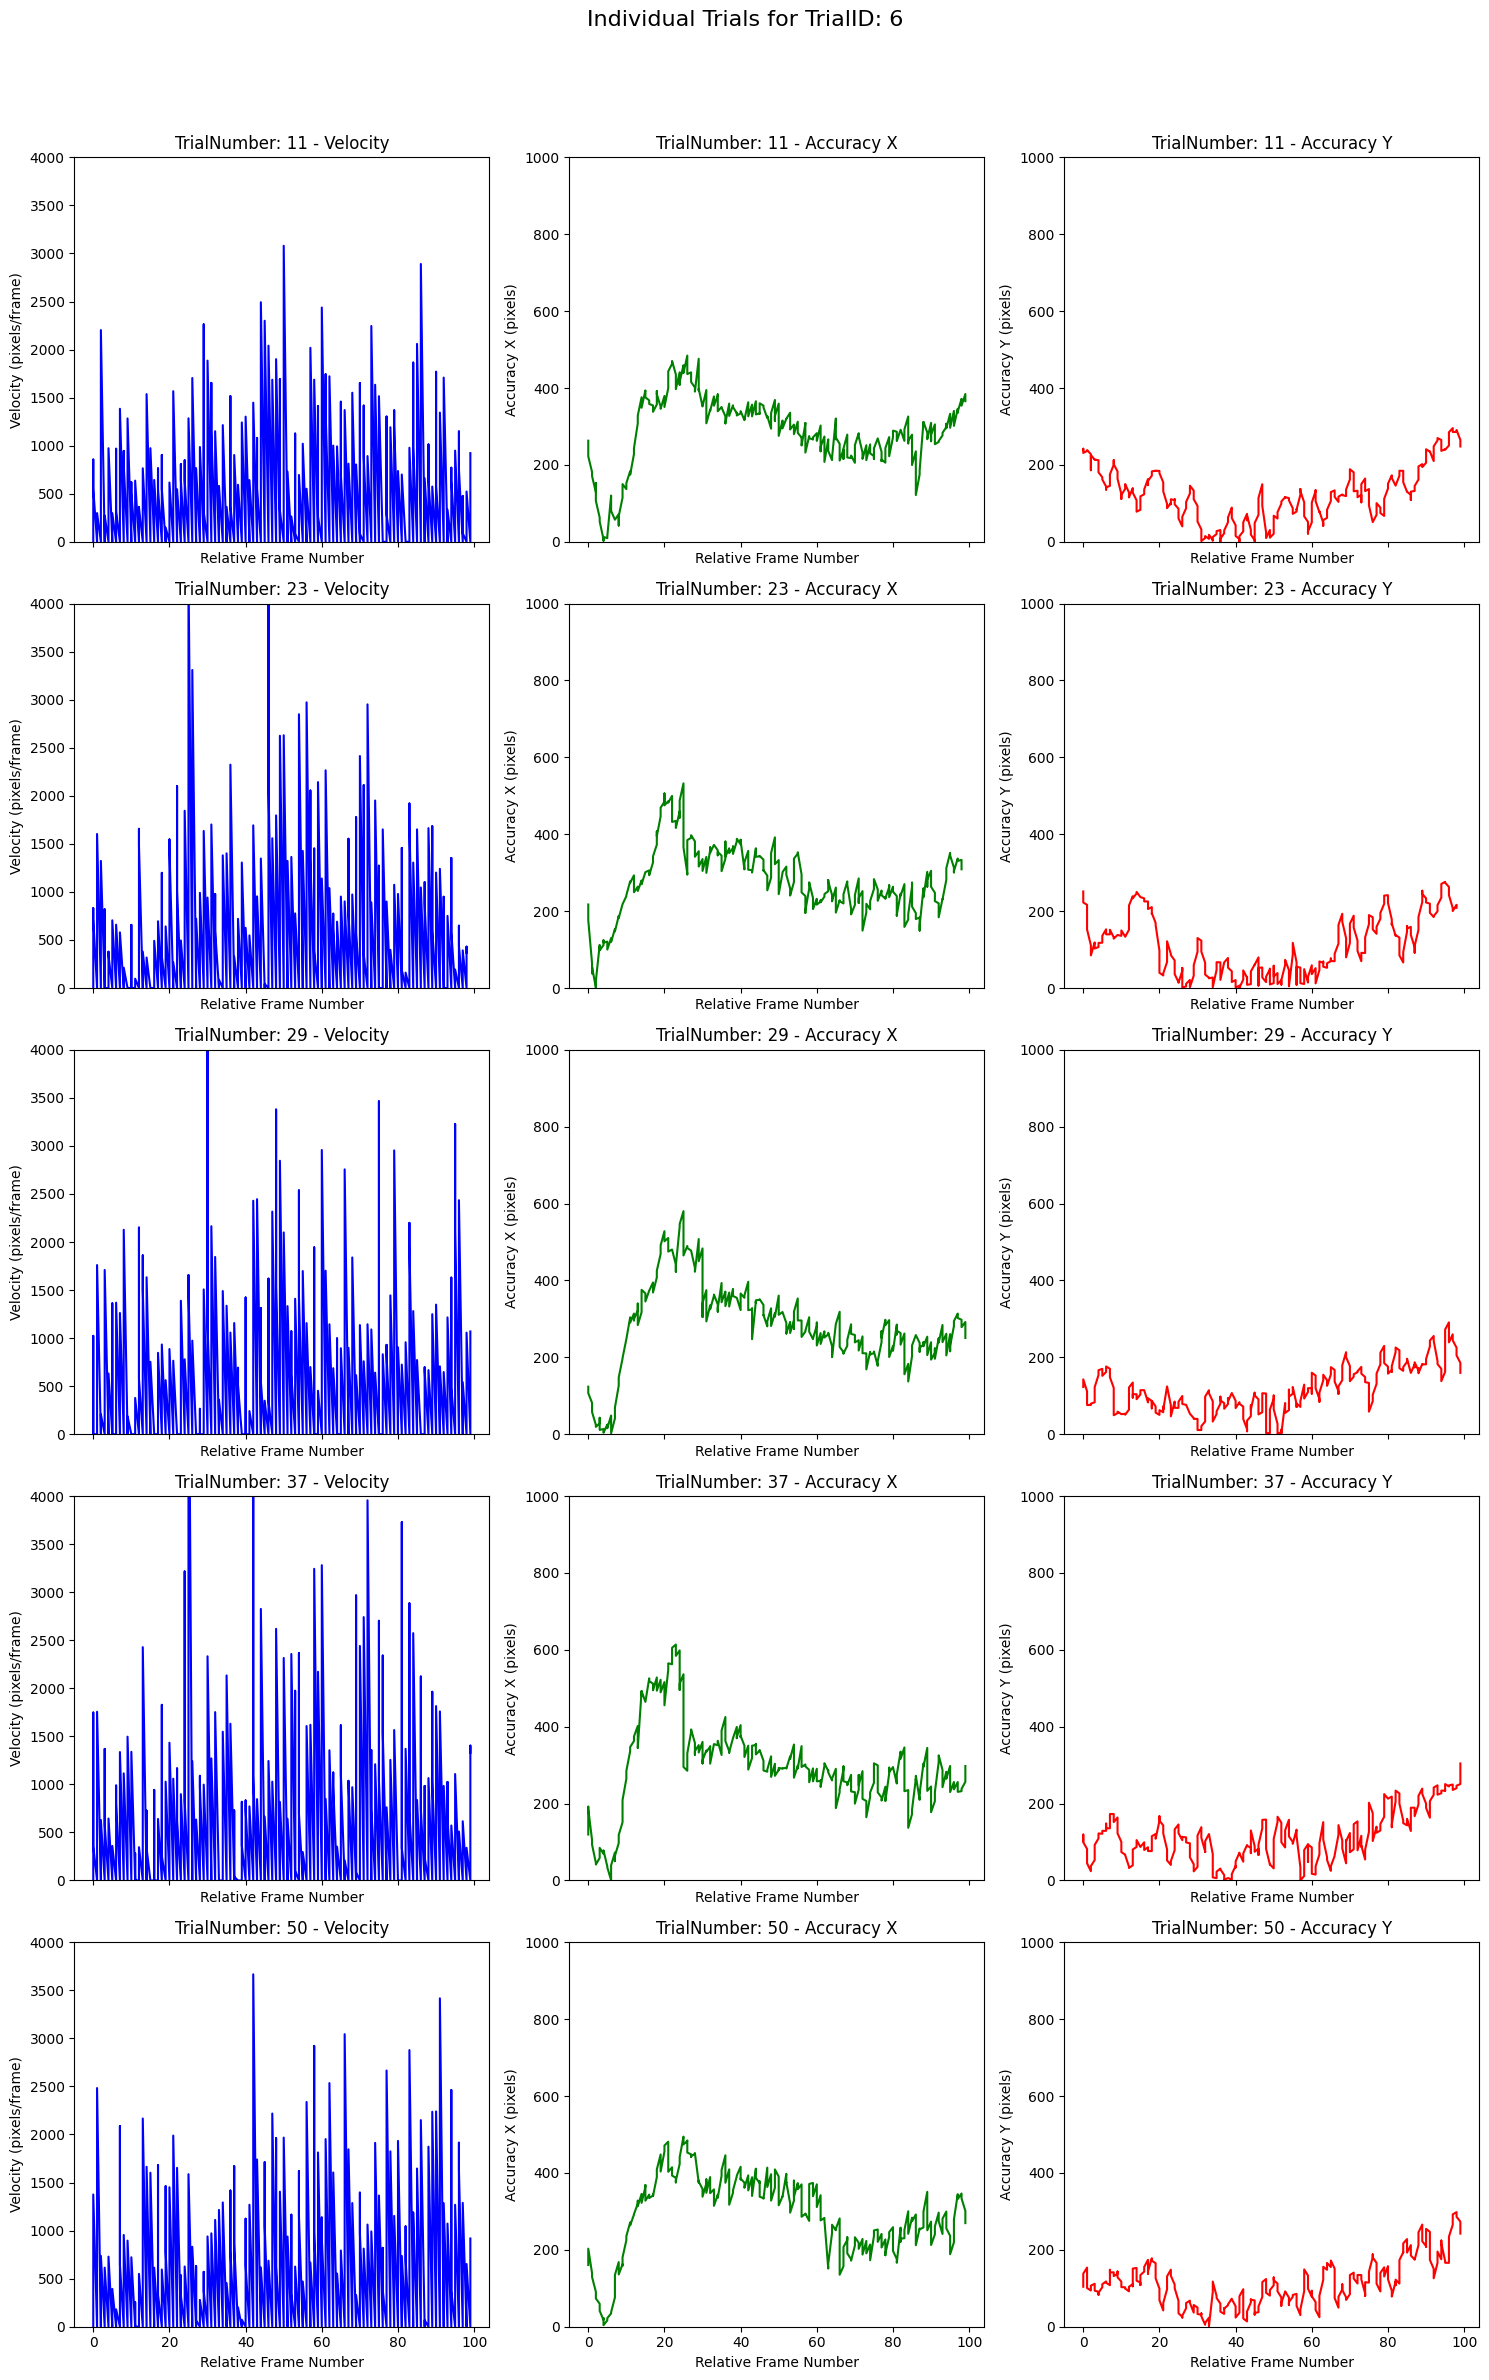

In [14]:
import matplotlib.pyplot as plt

import numpy as np

def compute_velocity_and_accuracy(df, screen_width, screen_height):
    # Compute Frame Difference
    df['FrameDiff'] = df['RelativeFrameNumber'].diff().fillna(1)  # Avoid division by zero, fill NaN with 1

    # Compute Position Difference for Velocity
    df['PosDiff'] = np.sqrt((df['BestPogX'].diff() ** 2) + (df['BestPogY'].diff() ** 2))
    df['PosDiff'].fillna(0, inplace=True)  # Replace NaN with 0
    df['Velocity'] = df['PosDiff'] / df['FrameDiff'].replace(0, 1e-5)  # Replace zero with a small value

    # Compute Accuracy Relative to Ball Position
    # Map gaze coordinates to screen width and height
    df['MappedPogX'] = df['BestPogX'] * screen_width
    df['MappedPogY'] = df['BestPogY'] * screen_height

    # Extract BallX and BallY from the ScreenBallPosition column, handling negative values
    df[['BallX', 'BallY']] = df['ScreenBallPosition'].str.extract(r'\((-?\d+\.?\d*)\s(-?\d+\.?\d*)\)').astype(float)

    # Filter out rows where BallX or BallY is negative
    df = df[(df['BallX'] >= 0) & (df['BallY'] >= 0)]

    # Calculate Accuracy in X and Y directions
    df['AccuracyX'] = np.abs(df['MappedPogX'] - df['BallX'])
    df['AccuracyY'] = np.abs(df['MappedPogY'] - df['BallY'])

    return df

# Function to plot individual trials within a given range for a specific TrialID
def plot_individual_trials(df, trial_id, trial_range=(0, 4)):
    # Filter the data for the specified TrialID
    trial_data = df[df['TrialID'] == trial_id]

    # Get the unique trial numbers within the specified range
    trial_numbers = trial_data['TrialNumber'].unique()
    start, end = trial_range
    selected_trials = trial_numbers[start:end+1]  # Select trials within the range

    # Create a figure for each trial in the range
    fig, axes = plt.subplots(len(selected_trials), 3, figsize=(15, 5 * len(selected_trials)), sharex=True)
    fig.suptitle(f'Individual Trials for TrialID: {trial_id}', fontsize=16)
    
    for i, trial_num in enumerate(selected_trials):
        single_trial_data = trial_data[trial_data['TrialNumber'] == trial_num]

        # Ensure we can handle subplots when there's only one row
        if len(selected_trials) == 1:
            axes_row = axes
        else:
            axes_row = axes[i]

        # Plot Velocity
        axes_row[0].plot(single_trial_data['RelativeFrameNumber'], single_trial_data['Velocity'], color='blue')
        axes_row[0].set_title(f'TrialNumber: {trial_num} - Velocity')
        axes_row[0].set_ylabel('Velocity (pixels/frame)')
        axes_row[0].set_xlabel('Relative Frame Number')
        axes_row[0].set_ylim([0, 4000])

        # Plot Accuracy X
        axes_row[1].plot(single_trial_data['RelativeFrameNumber'], single_trial_data['AccuracyX'], color='green')
        axes_row[1].set_title(f'TrialNumber: {trial_num} - Accuracy X')
        axes_row[1].set_ylabel('Accuracy X (pixels)')
        axes_row[1].set_xlabel('Relative Frame Number')
        axes_row[1].set_ylim([0, 1000])

        # Plot Accuracy Y
        axes_row[2].plot(single_trial_data['RelativeFrameNumber'], single_trial_data['AccuracyY'], color='red')
        axes_row[2].set_title(f'TrialNumber: {trial_num} - Accuracy Y')
        axes_row[2].set_ylabel('Accuracy Y (pixels)')
        axes_row[2].set_xlabel('Relative Frame Number')
        axes_row[2].set_ylim([0, 1000])

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit the title
    plt.show()

# Example usage
data = compute_velocity_and_accuracy(data, screen_width, screen_height)
plot_individual_trials(data, trial_id=6, trial_range=(0, 4))
